In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Hyperparameters
vocab_size = 8000 # 10000
embedding_dim = 16 
max_length = 32 # 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
# The dataset has 27,000 records, so we will use 20,000 for training
# and validate on the rest
training_size = 20000


In [4]:
# Getting the dataset from website
# As it doesn't exist in TFDS API
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-12-21 11:18:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  33.9MB/s    in 0.2s    

2020-12-21 11:18:26 (33.9 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [5]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

# Load each headline as a sentence and each is_sarcastic as a label
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            128000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 128,433
Trainable params: 128,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 15 # 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/15
625/625 - 5s - loss: 0.5528 - accuracy: 0.7088 - val_loss: 0.3911 - val_accuracy: 0.8362
Epoch 2/15
625/625 - 2s - loss: 0.3091 - accuracy: 0.8740 - val_loss: 0.3454 - val_accuracy: 0.8535
Epoch 3/15
625/625 - 2s - loss: 0.2392 - accuracy: 0.9047 - val_loss: 0.3500 - val_accuracy: 0.8512
Epoch 4/15
625/625 - 2s - loss: 0.1989 - accuracy: 0.9227 - val_loss: 0.3707 - val_accuracy: 0.8499
Epoch 5/15
625/625 - 2s - loss: 0.1695 - accuracy: 0.9359 - val_loss: 0.3997 - val_accuracy: 0.8463
Epoch 6/15
625/625 - 2s - loss: 0.1489 - accuracy: 0.9446 - val_loss: 0.4404 - val_accuracy: 0.8401
Epoch 7/15
625/625 - 2s - loss: 0.1335 - accuracy: 0.9523 - val_loss: 0.4706 - val_accuracy: 0.8384
Epoch 8/15
625/625 - 2s - loss: 0.1200 - accuracy: 0.9572 - val_loss: 0.5099 - val_accuracy: 0.8360
Epoch 9/15
625/625 - 2s - loss: 0.1088 - accuracy: 0.9611 - val_loss: 0.5557 - val_accuracy: 0.8283
Epoch 10/15
625/625 - 3s - loss: 0.0993 - accuracy: 0.9650 - val_loss: 0.6033 - val_accuracy: 0.8271

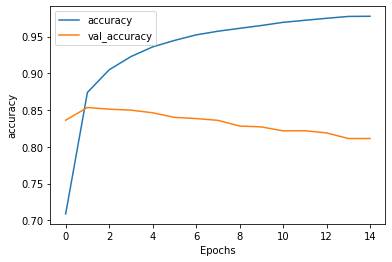

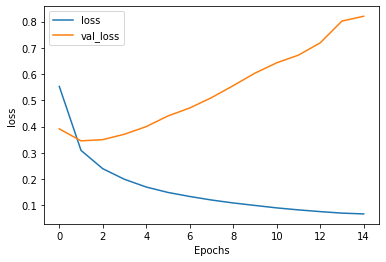

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(8000, 16)


In [15]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [16]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.80313677]
 [0.00098023]]
